# Install packages and download data

> We recommand using GPU backend

In [ ]:
! pip install expression-copilot[torch]
! pip install patchworklib

We download the CITE-seq dataset from NeurIPS 2021 Open Problems dataset (GSE194122).

In [ ]:
! wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed.h5ad.gz

--2025-10-14 05:32:32--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed.h5ad.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 615842052 (587M) [application/x-gzip]
Saving to: ‘GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz’

GSE194122_openprobl 100%[===================>] 587.31M  31.0MB/s    in 15s     

2025-10-14 05:32:48 (38.0 MB/s) - ‘GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz’ saved [615842052/615842052]



In [ ]:
! gunzip GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz

# Calculate EPS on multi-omics data (CITE-seq)

> (Estimated time: ~15 min)

In this vignette, we show how to calculate EPS and SPS on single cell multi-omics data. And found their relationship with gene expression predictability.



In [ ]:
import os
# os.environ["SCIPY_ARRAY_API"] = "1" # specific for colab cuml

In [ ]:
import scanpy as sc
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from expression_copilot import ExpressionCopilotModel

<Figure size 100x100 with 0 Axes>

In [ ]:
adata = sc.read_h5ad('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad')


We split the gene expression and surface protion

In [ ]:
gex = adata[:, adata.var['feature_types'] == 'GEX'].copy()
other = adata[:, adata.var['feature_types'] != 'GEX'].copy()

gex.X = gex.layers['counts'].copy()
sc.pp.highly_variable_genes(
    gex, layer="counts", n_top_genes=2000, flavor="seurat_v3", batch_key='batch', subset=True
)
del adata

Then we calculate EPS and run baseline model on every batch

In [ ]:
def run_batch(gex, other, batch):
    print(f'Preprocessing {batch}...')
    other.var["highly_variable"] = True
    sc.pp.scale(other, max_value=10)
    sc.pp.pca(other, n_comps=20)

    gex.obsm['X_adt_emb'] = other.obsm['X_pca']

    gex.X = gex.layers['counts']
    model = ExpressionCopilotModel(gex, image_key='X_adt_emb')

    eps = model.calc_metrics_per_gene()
    gene_metrics, _ = model.calc_baseline_metrics(method='mlp')
    gene_df = eps.merge(gene_metrics, left_index=True, right_index=True)
    return gene_df

In [ ]:
# This cell will take about 10 minutes in Colab, so take a coffee!
res_dict = {}
for batch in gex.obs['batch'].unique():
    gex_batch = gex[gex.obs['batch'] == batch].copy()
    other_batch = other[other.obs['batch'] == batch].copy()
    df = run_batch(gex_batch, other_batch, batch)
    res_dict[batch] = df
    print('='*100)

s1d1
Preprocessing s1d1...


2025-10-14 05:34:50.944 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
TTLL7      -0.188202
AL391807.1 -0.185196
PLS1       -0.169400
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2025-10-14 05:35:32.633 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.410104
spearman_corr    0.299910
pearson_pval     0.016366
spearman_pval    0.018190
rmse             0.825987
dtype: float64


s1d2
Preprocessing s1d2...


2025-10-14 05:35:35.539 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                EPS
GAL3ST4   -0.146126
LINC01800 -0.143587
IGLC5     -0.139070
2025-10-14 05:36:07.580 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.376169
spearman_corr    0.264945
pearson_pval     0.023565
spearman_pval    0.027642
rmse             0.837762
dtype: float64


s1d3
Preprocessing s1d3...


2025-10-14 05:36:10.826 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
ARG2       -0.218743
AC000065.1 -0.175332
SAMD15     -0.151477
2025-10-14 05:36:51.607 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.394338
spearman_corr    0.264962
pearson_pval     0.020277
spearman_pval    0.022229
rmse             0.824012
dtype: float64


s2d1
Preprocessing s2d1...


2025-10-14 05:36:56.426 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
              EPS
CEP112  -0.270627
IQCC    -0.211792
GAL3ST4 -0.201566
2025-10-14 05:37:27.114 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.345670
spearman_corr    0.269857
pearson_pval     0.016918
spearman_pval    0.018075
rmse             0.846754
dtype: float64


s2d4
Preprocessing s2d4...


2025-10-14 05:37:33.096 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
ARG2       -0.204562
AC118553.1 -0.149524
MROH8      -0.143252
2025-10-14 05:37:54.981 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.407614
spearman_corr    0.331798
pearson_pval     0.017207
spearman_pval    0.018671
rmse             0.852592
dtype: float64


s2d5
Preprocessing s2d5...


2025-10-14 05:37:59.202 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
MYT1       -0.312923
FO704657.1 -0.291017
ZC3H11B    -0.239025
2025-10-14 05:38:53.968 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.288895
spearman_corr    0.209825
pearson_pval     0.040115
spearman_pval    0.044850
rmse             0.827279
dtype: float64


s3d1
Preprocessing s3d1...


2025-10-14 05:38:58.963 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
ARHGEF10   -0.325652
ZNF415     -0.257691
AL391988.1 -0.165417
2025-10-14 05:39:22.179 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.273008
spearman_corr    0.205560
pearson_pval     0.018005
spearman_pval    0.020524
rmse             0.844178
dtype: float64


s3d6
Preprocessing s3d6...


2025-10-14 05:39:27.978 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
C11orf96   -0.171408
AC007262.2 -0.154468
LMOD3      -0.144635
2025-10-14 05:40:30.070 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.346866
spearman_corr    0.271978
pearson_pval     0.013502
spearman_pval    0.015523
rmse             0.868678
dtype: float64


s3d7
Preprocessing s3d7...


2025-10-14 05:40:36.830 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
HSD17B1    -0.238162
AL662884.5 -0.199595
TUBB3      -0.183979
2025-10-14 05:41:34.311 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.346112
spearman_corr    0.247657
pearson_pval     0.015218
spearman_pval    0.015639
rmse             0.851729
dtype: float64


s4d1
Preprocessing s4d1...


2025-10-14 05:41:38.720 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
              EPS
RHD     -0.193454
C4orf19 -0.155369
MYH3    -0.132086
2025-10-14 05:42:08.421 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.401501
spearman_corr    0.295360
pearson_pval     0.018724
spearman_pval    0.019278
rmse             0.841236
dtype: float64


s4d8
Preprocessing s4d8...


2025-10-14 05:42:10.955 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
              EPS
ZC3H11B -0.300863
KIF3C   -0.187500
MROH8   -0.178590
2025-10-14 05:42:35.622 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.446724
spearman_corr    0.330500
pearson_pval     0.016986
spearman_pval    0.017702
rmse             0.853190
dtype: float64


s4d9
Preprocessing s4d9...


2025-10-14 05:42:39.127 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
TTLL7      -0.208597
AL591043.2 -0.204881
SYP        -0.166553
2025-10-14 05:43:28.482 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.412032
spearman_corr    0.306243
pearson_pval     0.015245
spearman_pval    0.014172
rmse             0.844151
dtype: float64


## Plot
Firstly, we visualize the relationship between EPS and per-gene prediction performance (Pearson correlation) in every batch

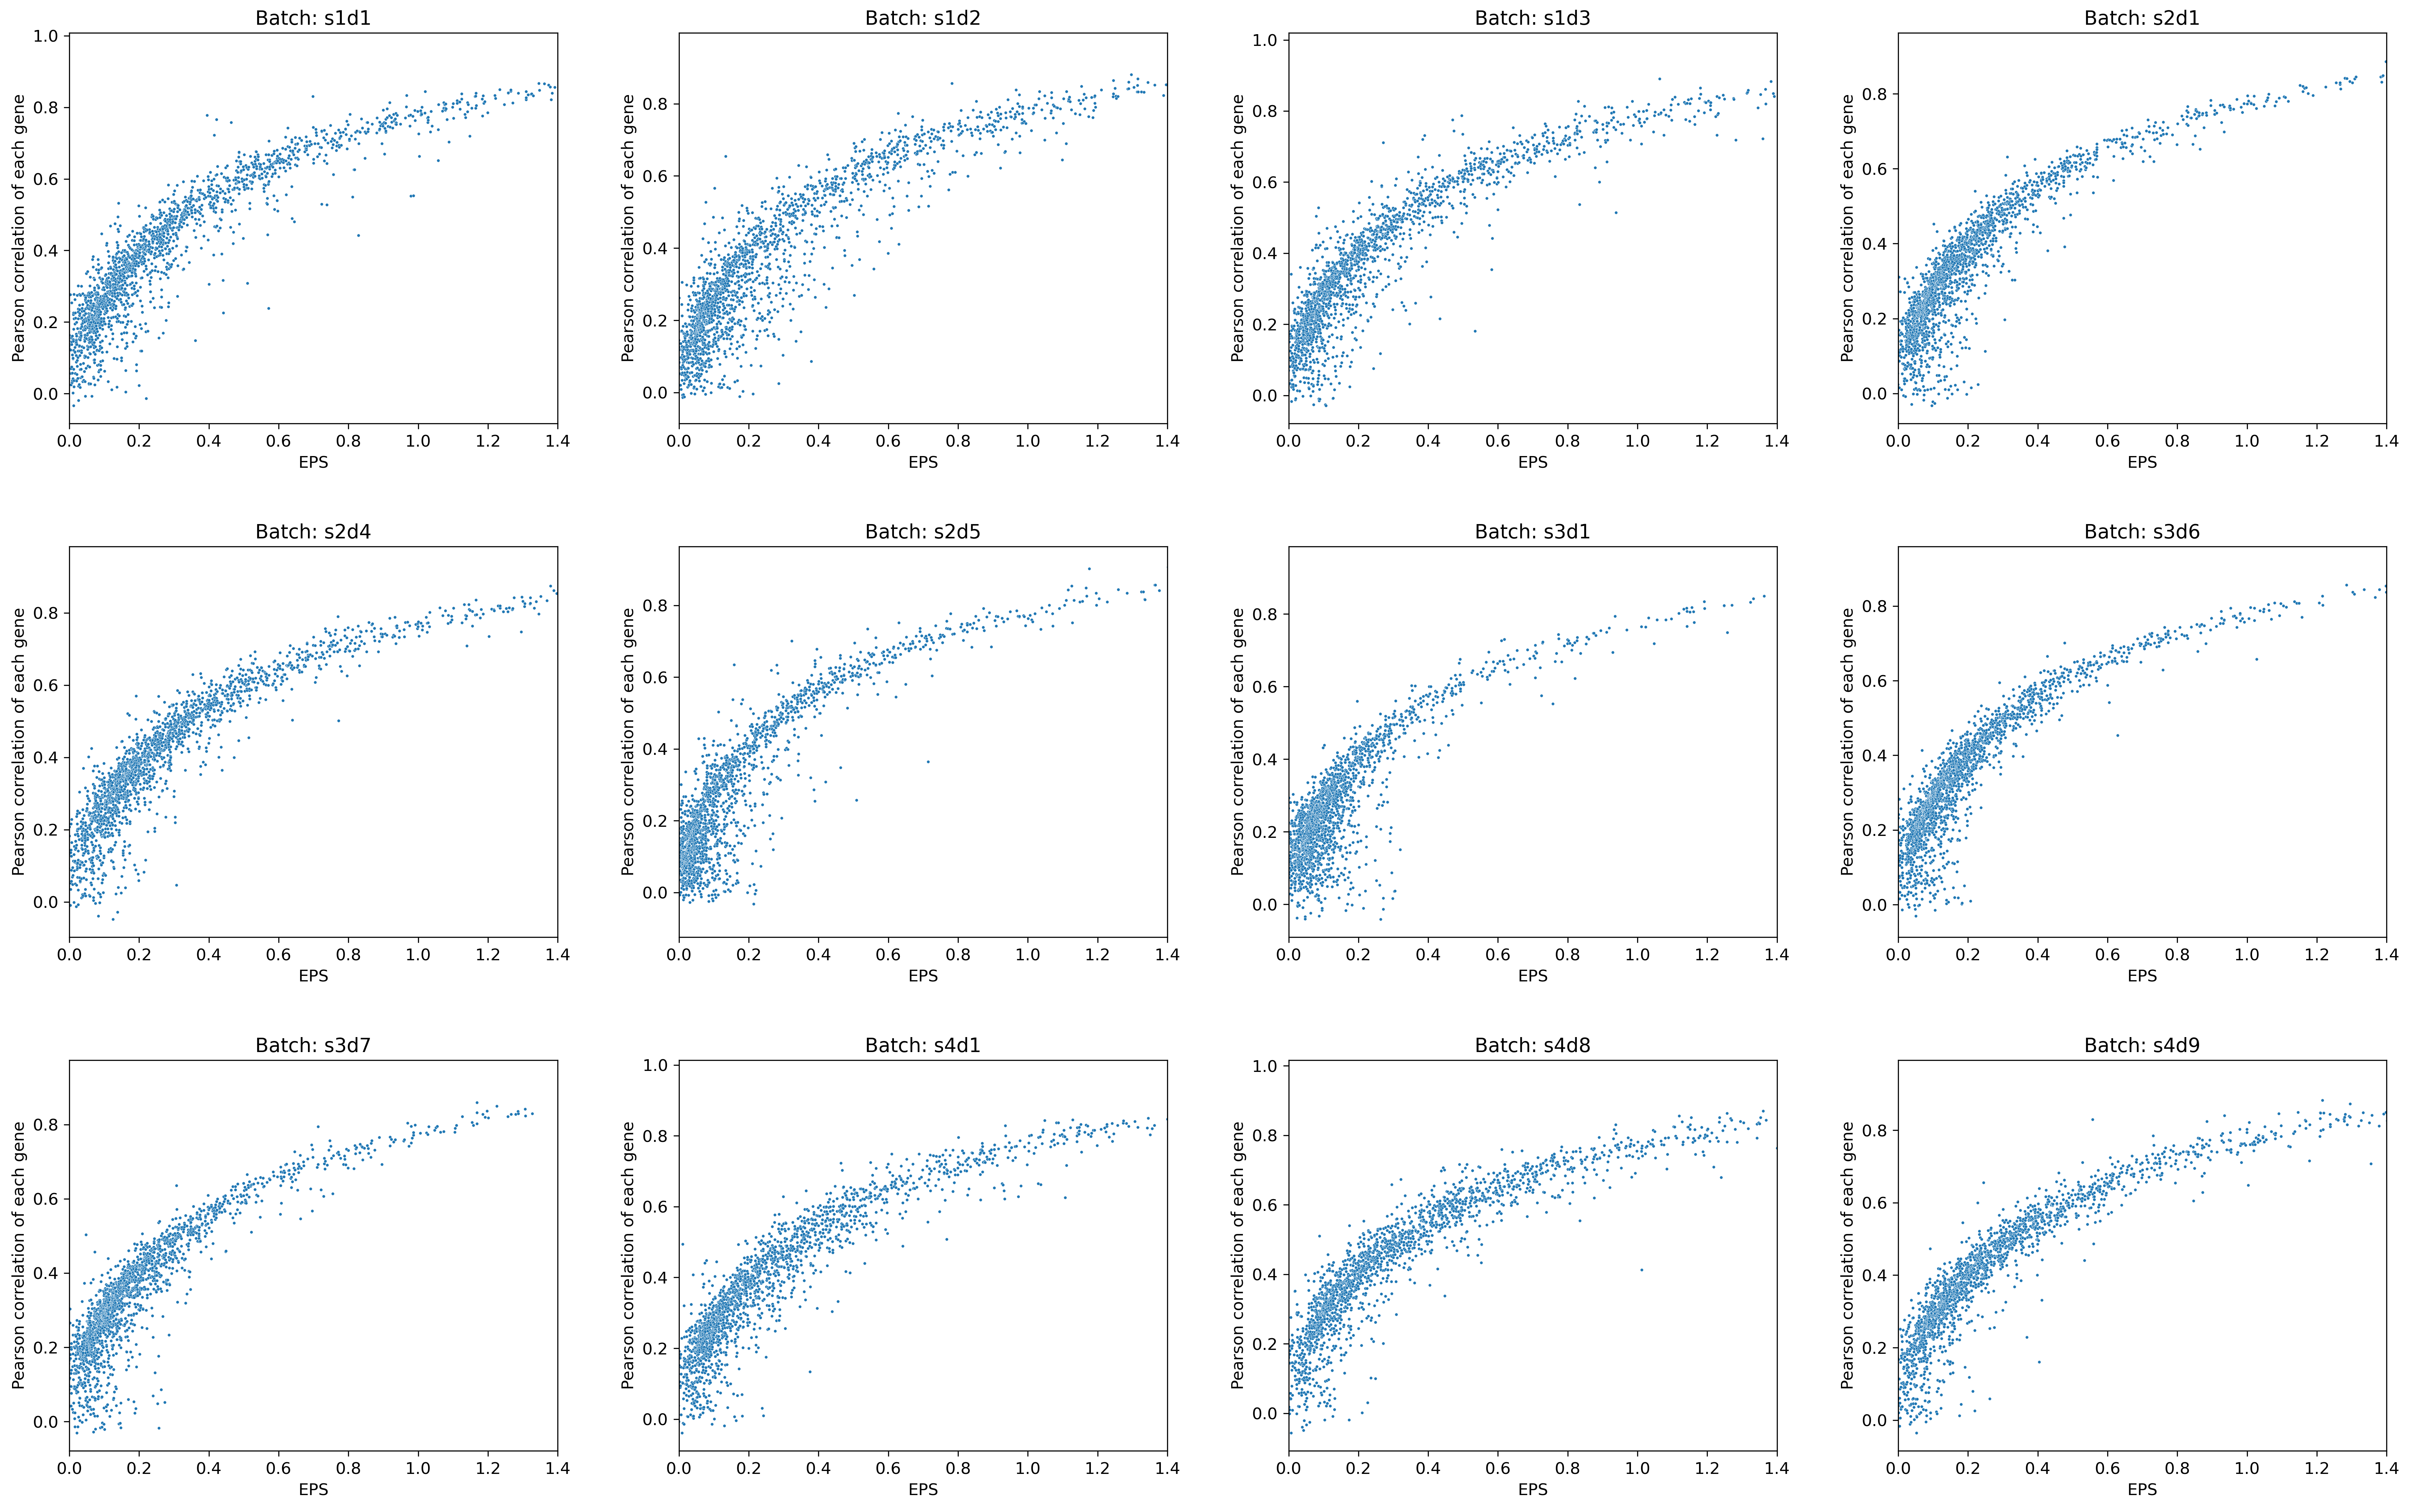

In [ ]:
plot_dict = {}
for i, (batch, metrics) in enumerate(res_dict.items()):
    tmp_ax = pw.Brick(figsize=(5,4))
    ax = sns.scatterplot(x=metrics['EPS'], y=metrics['pearson_corr'], s=5, ax=tmp_ax)
    ax.set_title(f'Batch: {batch}')
    ax.set_ylabel('Pearson correlation of each gene')
    ax.set_xlim(0, 1.4)
    plot_dict[i] = tmp_ax

(plot_dict[0] | plot_dict[1] | plot_dict[2] | plot_dict[3])/ \
(plot_dict[4] | plot_dict[5] | plot_dict[6] | plot_dict[7])/ \
(plot_dict[8] | plot_dict[9] | plot_dict[10] | plot_dict[11])


Then we plot to visualize the relationship between SPS and slice level prediction performance (Pearson correlation)

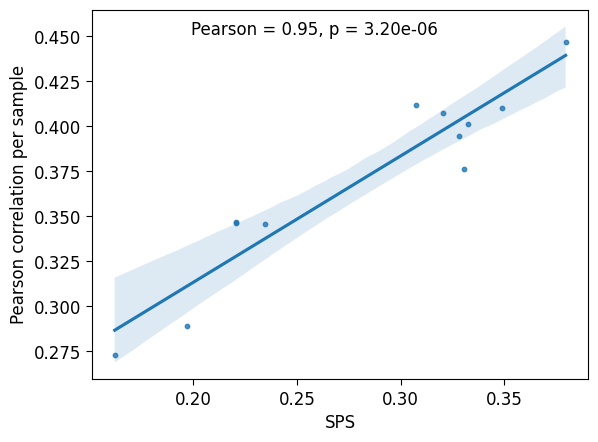

In [ ]:
eps_list, pearson_list = [], []
for batch, metrics in res_dict.items():
    eps_list.append(metrics['EPS'].mean())
    pearson_list.append(metrics['pearson_corr'].mean())
tmp_df = pd.DataFrame({'EPS': eps_list, 'pearson_corr': pearson_list, 'batch': list(res_dict.keys())})
pearson, p_val = pearsonr(tmp_df["EPS"], tmp_df["pearson_corr"])
ax = sns.regplot(tmp_df, x="EPS", y="pearson_corr", scatter_kws={"s": 10})
ax.text(0.2, 0.97, f"Pearson = {pearson:.2f}, p = {p_val:.2e}", transform=ax.transAxes, fontsize=12,
        verticalalignment="top", )
ax.set_xlabel('SPS')
ax.set_ylabel('Pearson correlation per sample')
plt.show()